# Clustering Concepts through Semantic Similarity Measures
When presented with a body of text, word clouds can be used as a rudimentary way to get an overview of what the text is about. However, when one needs to find a good _abstraction_ of the topics in the text, we may need to look at techniques based on semantic similarity. This is an example of such an approach.

## Step 1: Read the text file
In this case, we use annotations from sketches created by a team of students brainstorming ideas for a toy. But first, some imports.

In [164]:
# Imports for plotting
import pylab
import matplotlib.pyplot as plt
import matplotlib

# Imports for matrix manipulation
import numpy as np
from numpy import genfromtxt

# Import for clustering calculations
import scipy.cluster.hierarchy as sch

# Imports for printing
import pprint

# Imports for text processing
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords, wordnet_ic
from nltk.stem import WordNetLemmatizer, PorterStemmer
%matplotlib inline 
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
filesPath = 'D:/jupyter_notebooks/private/concept_representation/'
fileslist = ['representation_team01.txt']

def readFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    outString = ''
    for fileName in fileNamesList:
        with open(filePath + fileName, 'r', encoding='utf8') as fObj:
            temp = fObj.read()
            outString += temp
    return outString.lower()
        
readText = readFiles(fileslist, filesPath)
print("Read", readText.count('\n'), "lines of text.")

Read 54 lines of text.


**NOTE:** The above function takes on a list of files so that you have the flexibility of providing one file for analysis, or clump together a list of files for analysis.

## Step 2: Tokenizing, stop word removal, and lemmatization
We split the text into individual words, and remove "stop words" -- common words that add little meaning to the text (articles, pronouns, prepositions etc.)
An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are treated the same. 

In [166]:
words = nltk.word_tokenize(readText)
impWords = [w for w in words if not w in stopwords.words('english')]
numRemoved = len(words) - len(impWords)
print("Removed", numRemoved, "stop words from a total of", len(words), "words.")

wnL = WordNetLemmatizer()
ps = PorterStemmer()

def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0 :
            synset = synsets[0] # assume most common use of the word
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return lemmaList

lemmatizedWords = list(set([wnL.lemmatize(w) for w in impWords]))
print("List of words then reduced to", len(lemmatizedWords), "unique, lemmatized words.")



Removed 6 stop words from a total of 100 words.
List of words then reduced to 82 unique, lemmatized words.


## Step 3: Plot similarities between words
We use the lin similarity metric to calculate similarities between every word and every other word in the list.

Synset not found for foosball
Synset not found for ?
Synset not found for penny-farthing
Synset not found for app
Synset not found for self-start
Synset not found for rc
Number of words in matrix: 68


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


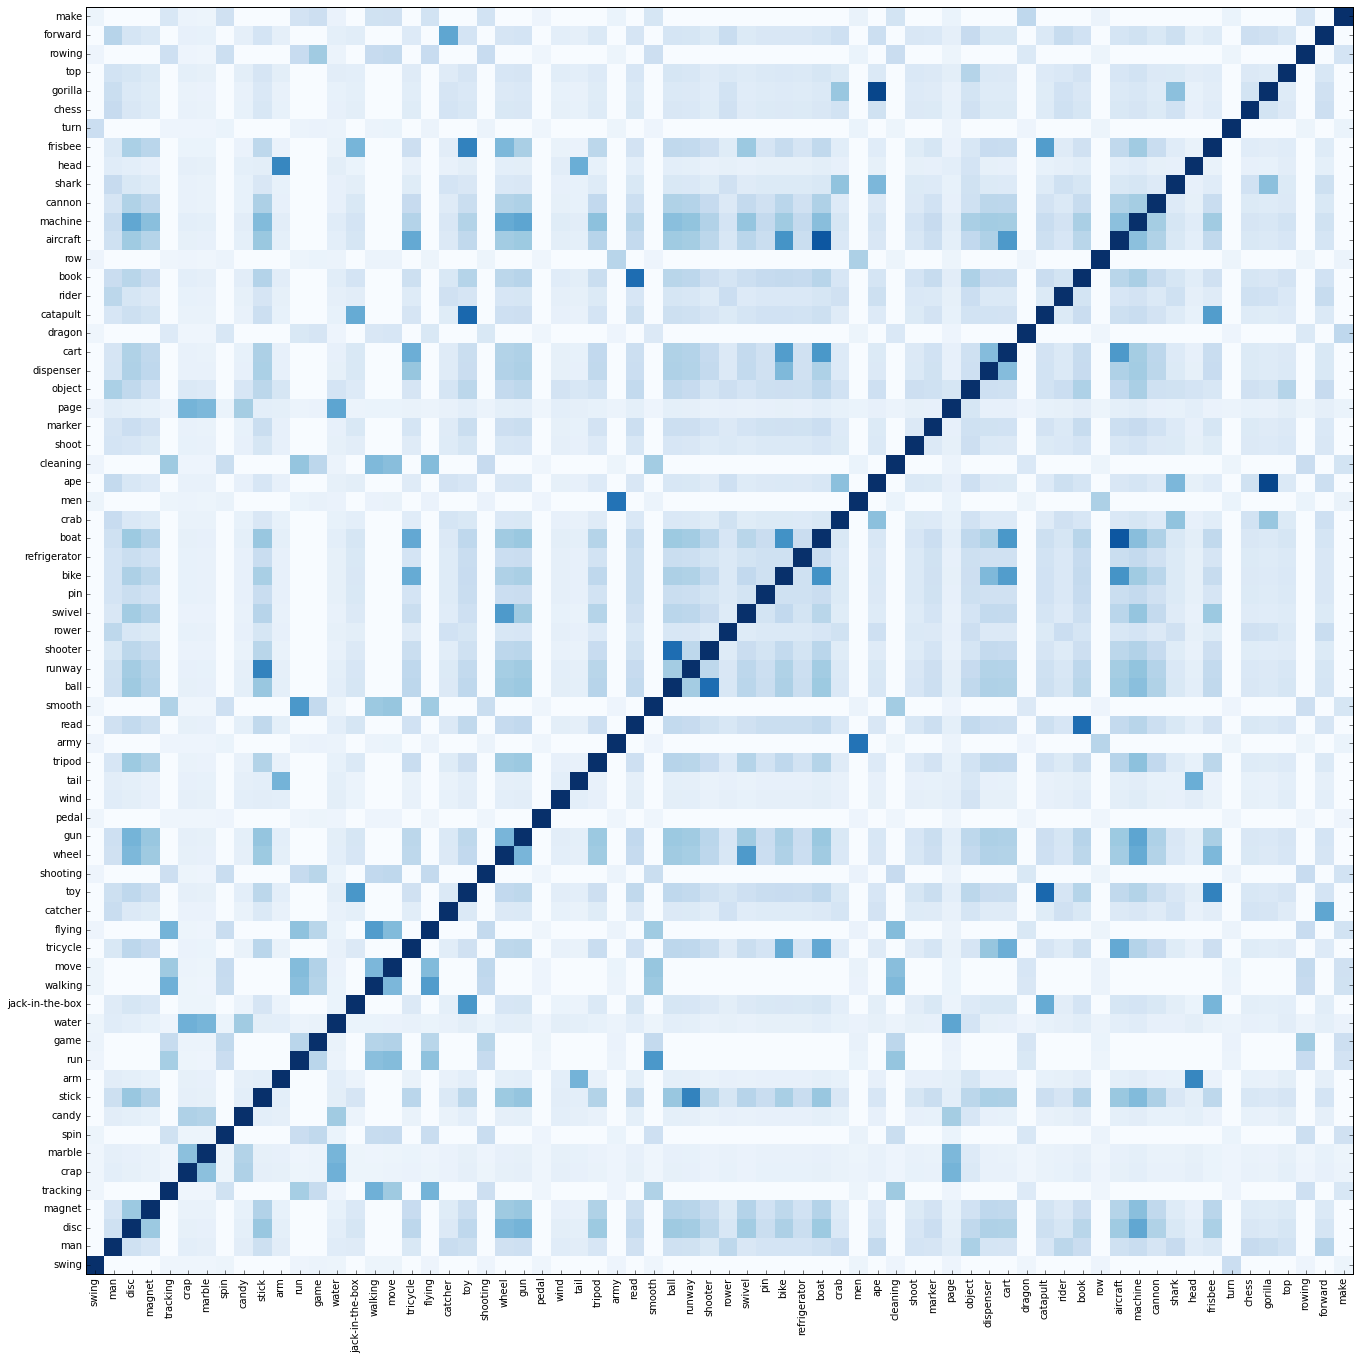

In [181]:
def similarityMat(words, infoCorpus, pos='n'):
    simMatrix = []
    synsets = []
    finalwords = []
    # Identify words for which similarities can be computed. 
    # This excluldes adjectives (a), satellite adjectives (s), and adverbs (r).
    # Also discard words for which synsets do not exist: these words lie outside
    # the WordNet hierarchy.
    for token in words:
        tempSyn = wn.synsets(token)
        if len(tempSyn) > 0 :
            for syn in tempSyn:
                if (set(syn.pos()).intersection(set([pos]))):
                    synsets.append(tempSyn[0])
                    finalwords.append(token)
                    break
        else :
            print("Synset not found for", token)
    print("Number of words in matrix:", len(synsets))
    rowLabels = finalwords
    colLabels = finalwords
    # For the shortlisted words and their corresponding synsets, 
    # identify the semantic similarity (inverse of distance) between
    # every word and every other word.
    for i, synsetLH in enumerate(synsets):
        simRow = []
        for j, synsetRH in enumerate(synsets):
            if synsetLH.pos() == synsetRH.pos() :
                similarity = synsetLH.lin_similarity(synsetRH, infoCorpus)
                if (similarity == -0.0):
                    similarity = 0.0
            else :
                similarity = 0.0
            simRow.append(similarity)
        if i == 0 :
            simMatrix = simRow
        else:
            simMatrix = np.vstack((simMatrix, simRow))
    # Draw the matrix
    fig = pylab.figure(figsize=(20,20))
    ax = fig.add_axes([0.1, 0.1, 0.88, 0.88]) # left, bottom, width, height
    ax.set_xlim(0, len(colLabels))
    ax.set_ylim(0, len(rowLabels))
    simMatrixPlot = ax.pcolor(simMatrix, cmap=plt.cm.Blues)
    ax.xaxis.tick_bottom()
    ax.set_xticks(np.arange(len(colLabels)) + 0.5, minor=False)
    ax.set_xticklabels(colLabels, rotation='vertical', minor=False)
    ax.set_yticks(np.arange(len(rowLabels)) + 0.5, minor=False)
    ax.set_yticklabels(rowLabels, minor=False)
    plt.show(fig)
    return [simMatrix, finalwords, synsets]

outMatrix,outwords, outSynsets = similarityMat(lemmatizedWords, wordnet_ic.ic('ic-bnc-add1.dat'), pos='n')

## Step 4: Split the list into lists having the same part of speech
For meaningful hierarchical clustering, the words in a list to be clustered must all have the same part of speech.
For instance, there can be no hypernym between a verb and a noun. 
This way the hierarchical clusters will have some meaning, instead of getting garbled together. 

In [182]:
# Create a synset dict based on the last output
# this will be useful in keeping the meanings consistent
# when identifying least common hypernyms later on
synsetDict = {}
for i, synset in enumerate(outSynsets):
    synsetDict[outwords[i]] = synset

posList = list(set([x.pos() for x in list(synsetDict.values())]))

nounList = [synsetDict[x] for x in outwords if synsetDict[x].pos() == 'n']
verbList = [synsetDict[x] for x in outwords if synsetDict[x].pos() == 'v']
print("List of Nouns:")
print(nounList)
print("\nList of Verbs:")
print(verbList)

List of Nouns:
[Synset('swing.n.01'), Synset('man.n.01'), Synset('phonograph_record.n.01'), Synset('magnet.n.01'), Synset('trailing.n.01'), Synset('crap.n.01'), Synset('marble.n.01'), Synset('spin.n.01'), Synset('candy.n.01'), Synset('stick.n.01'), Synset('arm.n.01'), Synset('run.n.01'), Synset('game.n.01'), Synset('water.n.01'), Synset('jack-in-the-box.n.01'), Synset('walk.n.01'), Synset('move.n.01'), Synset('tricycle.n.01'), Synset('flight.n.02'), Synset('catcher.n.01'), Synset('plaything.n.01'), Synset('shooting.n.01'), Synset('wheel.n.01'), Synset('gun.n.01'), Synset('pedal_point.n.01'), Synset('wind.n.01'), Synset('tail.n.01'), Synset('tripod.n.01'), Synset('army.n.01'), Synset('read.n.01'), Synset('smooth.n.01'), Synset('ball.n.01'), Synset('track.n.09'), Synset('taw.n.02'), Synset('oarsman.n.01'), Synset('swivel.n.01'), Synset('pin.n.01'), Synset('motorcycle.n.01'), Synset('refrigerator.n.01'), Synset('boat.n.01'), Synset('crab.n.01'), Synset('work_force.n.01'), Synset('ape.n.01

## Step 4: Compute hierarchical clusters
Using agglomerative hierarchical clustering, the above matrix can be rearranged hierarchically by identifying pairs of rows that are closest in values to each other, then finding rows that are closet in value to these pairs, and so on until we complete the entire matrix.

method = ward
original matrix size: 68 X 68
length of original word list: 68
reduced matrix size: 68 X 68
length of reduced word list: 68


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


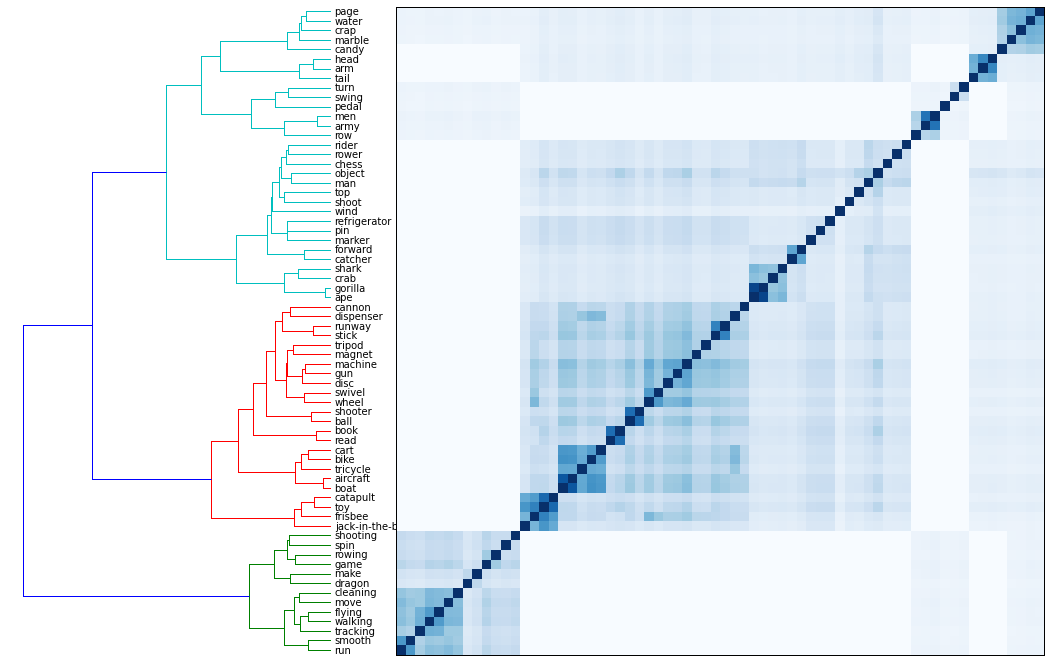

DENDROGRAM IN LIST FORM:
[[[['run', 'smooth'],
   [['tracking', ['walking', 'flying']], ['move', 'cleaning']]],
  [['dragon', 'make'], [['game', 'rowing'], ['spin', 'shooting']]]],
 [[['jack-in-the-box', ['frisbee', ['toy', 'catapult']]],
   [[['boat', 'aircraft'], ['tricycle', ['bike', 'cart']]],
    [['read', 'book'],
     [['ball', 'shooter'],
      [[['wheel', 'swivel'],
        [['disc', ['gun', 'machine']], ['magnet', 'tripod']]],
       [['stick', 'runway'], ['dispenser', 'cannon']]]]]]],
  [[[['ape', 'gorilla'], ['crab', 'shark']],
    [['catcher', 'forward'],
     [['marker', ['pin', 'refrigerator']],
      ['wind',
       [['shoot', 'top'],
        [['man', 'object'], ['chess', ['rower', 'rider']]]]]]]],
   [[['row', ['army', 'men']], ['pedal', ['swing', 'turn']]],
    [['tail', ['arm', 'head']],
     ['candy', ['marble', ['crap', ['water', 'page']]]]]]]]]
##############################################################################

HYPERNYM TREE CORRESPONDING TO DENDROGRAM

In [187]:
# The genTree function is called by the genClusters function. 
# See comments that precede the function call (inside genClusters)
def genTree(treeObj, wordList):
    # generates a list representation from the tree object returned by the
    # linkage function (sch.linkage)
    if treeObj.is_leaf():
        return wordList[treeObj.get_id()]
    else :
        return [genTree(treeObj.get_left(), wordList),
                genTree(treeObj.get_right(), wordList)]

def genTreeNums(treeObj):
    # generates a list representation from the tree object returned by the
    # linkage function (sch.linkage)
    if treeObj.is_leaf():
        return treeObj.get_id()
    else :
        return [genTreeNums(treeObj.get_left()), 
                genTreeNums(treeObj.get_right())]

def findSynsetItemForPOS(hypset, inpos):
    # Given a synset and a part of speech tag,
    # returns the synset item whose POS tag matches the input
    # if no match found, returns an empty string
    result = False
    hypout = ''
    for hyp in hypset:
        if hyp.pos() == inpos :
            hypout = hyp
            result = True
            break
    return [result, hypout]
    
def get_lch(word1, word2):
    # Given single items from two synset (typically the first one from
    # each), calculate the lowest common hypernyms, and return the first
    # one. This is the same hypernyms that is used for the resnik and lin
    # similarity measures.
    # Note that if the hypernym of synsetItem1 and synsetItem2 is, say,
    # hyp1, then synsetItem1.res_similarity(synsetItem2, brown_ic) gives
    # the same result as synsetItem1.res_similarity(hyp1, brown_ic)
    # We can use this with the results from the agglomerative clustering
    # to find out what hypernyms correspond to all branches in the
    # dendrogram
    synset1 = wn.synsets(word1)
    synset2 = wn.synsets(word2)
    for i, synsetLH in enumerate(synset1):
        for j, synsetRH in enumerate(synset2):
            if (synsetLH.pos() == synsetRH.pos() and not
               set([synsetLH.pos()]).intersection(set(['a','s','r']))):
                hypernymList = synsetLH.lowest_common_hypernyms(synsetRH)
                if len(hypernymList) > 0 :
                    hypernym = hypernymList[0]
                else :
                    print("No hypernym between", synsetLH, "and", synsetRH)
                return hypernym.name().split('.')[0]

    
def get_lch1(term1, term2, refDict={}):
    # The two input terms could be either WordNet synset items,
    # or just words (or one of each)
    # If they are both synset items, directly calculate the 
    # lowest common hypernyms, and return the first one.
    # If either one is a word, then find the corresponding synset,
    # iterate through the items of the synset until a part-of-speech 
    # match is found, and then find the least common hypernym
    # NOTE that we are assuming both synset items provided have
    # the SAME part of speech (noun or verb)
    hypernym = ''
    # Check if either of the two input terms are part of the provided
    # dict of synset items. This means they are part of the original
    # list of items. Use the same instance as the original, then.
    done = False
    print(term1)
    print(set(refDict.keys()))
    if len(set(refDict.keys()).intersection({term1})) > 0 :
        termSyn1 = refDict[term1]
        if len(set(refDict.keys()).intersection({term2})) > 0 :
            termSyn2 = refDict[term2]
            hypernymSet = termSyn1.lowest_common_hypernyms(termSyn2)
            hypernym = findSynsetItemForPOS(hypernymSet, termSyn1.pos())
        else :
            synset2 = wn.synsets(term2)
            for j, synsetRH in enumerate(synset2):
                if done: break
                if (termSyn1.pos() == synsetRH.pos()):
                    hypernymSet = termSyn1.lowest_common_hypernyms(synsetRH)
                    hypernym, done = findSynsetItemForPOS(hypernymSet, termSyn1.pos())
                    if done : break
    else :
        synset1 = wn.synsets(term1)
        if len(set(refDict.keys()).intersection({term2})) > 0 :
            termSyn2 = refDict[term2]
            for i, synsetLH in enumerate(synset1):
                if done : break
                if (synsetLH.pos() == termSyn2.pos()):
                    hypernymSet = synsetLH.lowest_common_hypernyms(termSyn2)
                    hypernym, done = findSynsetItemForPOS(hypernymSet, termSyn1.pos())
                    if done : break
        else :
            synset2 = wn.synsets(term2)
            for i, synsetLH in enumerate(synset1):
                if done:break
                for j, synsetRH in enumerate(synset2):
                    if done: break
                    if (synsetLH.pos() == synsetRH.pos()):
                        hypernymSet = synsetLH.lowest_common_hypernyms(synsetRH)[0]
                    hypernym, done = findSynsetItemForPOS(hypernymSet, termSyn1.pos())
                    if done : break
    if (hypernym == ''):
        print("ERROR: No hypernym found between", term1, "and", term2)
    return hypernym

def getHypernyms(inputList):
    # this takes the dendrogram structure of words in a list format
    # (this format is a list of lists, where each list is a list of either
    # two lists, or a string and a list, or a string and a string.
    # It returns a list which includes hypernyms, so that each list is now
    # a list of three items, the third item being the hypernym of the
    # remaining two.
    if len(inputList) == 2:
        if isinstance(inputList[0], str):
            if isinstance(inputList[1], str):
                tempHyp = str(get_lch(inputList[0], inputList[1]))
                return [tempHyp, inputList[0], inputList[1]]
            else :
                lowerHypList = getHypernyms(inputList[1])
                tempHyp = str(get_lch(inputList[0], lowerHypList[0]))
                return [tempHyp, inputList[0], lowerHypList]
        else :
            lowerHypList1 = getHypernyms(inputList[0])
            lowerHypList2 = getHypernyms(inputList[1])
            tempHyp = str(get_lch(lowerHypList1[0], lowerHypList2[0]))
            return [tempHyp, lowerHypList1, lowerHypList2]
    else : #this means the hypernym list is already computed
        return inputList

def getHypernymsAlt(inputList, inputSynsetDict):
    # this takes the dendrogram structure of words in a list format
    # (this format is a list of lists, where each list is a list of either
    # two lists, or a string and a list, or a string and a string.
    # It returns a list which includes hypernyms, so that each list is now
    # a list of three items, the third item being the hypernym of the
    # remaining two.
    if len(inputList) == 2:
        # Check if the first instance in the list is a string or a synset item (object)
        if isinstance(inputList[0], str or object):
            if isinstance(inputList[1], str or object):
                tempHyp = get_lch(inputList[0], inputList[1])
                return [tempHyp, inputList[0], inputList[1]]
            else :
                lowerHypList = getHypernyms(inputList[1], inputSynsetDict)
                tempHyp = get_lch(inputList[0], lowerHypList[0])
                return [tempHyp, inputList[0], lowerHypList]
        else :
            lowerHypList1 = getHypernyms(inputList[0], inputSynsetDict)
            lowerHypList2 = getHypernyms(inputList[1], inputSynsetDict)
            tempHyp = get_lch(lowerHypList1[0], lowerHypList2[0])
            return [tempHyp, lowerHypList1, lowerHypList2]
    else : #this means the hypernym list is already fully computed
        return inputList


def genClusters(simMatrix, words, cMethod, wordSynsetDict):
    # clusters the matrix with the specified method, retrieves the words
    # corresponding to the matrix rows, supplied in a word file
    D1 = simMatrix
    wordsList1 = words
    # refer custom function 'reomveEmptyBands' for details on 
    # what the next line does
    # D, wordsList = removeEmptyBands(D1, wordsList1)
    D, wordsList = D1, wordsList1
    # Output details of the computation
    print('method =', cMethod)
    print('original matrix size:',str(len(D1)),'X',str(len(D1[0]))) 
    print('length of original word list:', str(len(wordsList1)))
    print('reduced matrix size:',str(len(D)),'X',str(len(D[0]))) 
    print('length of reduced word list:',str(len(wordsList)))
    
    # Fist, set up the figure
    fig = pylab.figure(figsize=(15,15))
    # fig.patch.set_visible(False) # plot on transparent background
    ax1 = fig.add_axes([0.01,0.1,0.30,0.6], # left, bottom, width, height
                       {'width':0.05, 
                        'edgecolor':'k',
                        'backgroundcolor':'w'}) 
    # values of left...height are in fractions of figure width & height
    spines_to_remove = ['left', 'bottom', 'right', 'top']
    for spine in spines_to_remove:
        ax1.spines[spine].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Perform agglomerative clustering by specified method
    Y = sch.linkage(D, method=cMethod)
    # Compute and plot dendrograms
    # This is done twice for row- and column-wise clustering.
    # Note that it is possible to use SEPARATE methods for the
    # rows and columns. This might make for some interesting
    # comparisons later, but for now, let's just consider symmetrical
    # clustering
    Z1 = sch.dendrogram(Y, orientation='right')
    Z2 = sch.dendrogram(Y, orientation='right', labels = wordsList, leaf_font_size=9)
    
    # Plot distance matrix.
    axmatrix = fig.add_axes([0.37,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.Blues)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    reorderedWords = Z2['ivl']
    axmatrix.set_xticklabels(reorderedWords[:-1])
    plt.show(fig)
    # generate hypernym tree from dendrogram
    objTree = sch.to_tree(Y, rd=False)
    wordTreeList = genTree(objTree, wordsList)
    wordNumsList = genTreeNums(objTree)
    print("DENDROGRAM IN LIST FORM:")
    pprint.pprint(wordTreeList)
    print('##############################################################################\n')
    hypernymsList = getHypernyms(wordTreeList)
    print("HYPERNYM TREE CORRESPONDING TO DENDROGRAM:")
    pprint.pprint(hypernymsList, indent=4)

genClusters(outMatrix, outwords, 'ward', synsetDict)

In [ ]:
testDict = { 'good': 'ok', 'bad': 'nok'}
len(set(testDict.keys()).intersection({'ok'}))